In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
from decimal import *
import math

In [7]:
freespace = """
-75,58	-85,58
-75,74	-85,74
-75,92	-85,92
-76,11	-86,11
-76,33	-86,33
-76,55	-86,55
-76,78	-86,78
-77,01	-87,01
-77,24	-87,24
-77,48	-87,48
-77,71	-87,71
-77,94	-87,94
-78,17	-88,17
-78,40	-88,40
-78,63	-88,63
-78,85	-88,85
""".replace(',', '.').split()
#First column is patch antenna second is isotropic

freespace = np.array([float(i) for i in freespace]).reshape(-1, 2)

fsPatch, fsIso = (freespace[:, 0], freespace[:, 1])
fsPatch -= 10

with open("data.raw", "r") as f:
    rawdata = f.read().replace(',','.').replace('\n', ';').split(';')

data = np.array([float(i) for i in rawdata[:-1]], dtype=np.float32).reshape(-1, 5)

d, pwDir, pwIso = (data[:-35, 0], data[:-35, 1], data[:-35, 2])

h, pwAltura = (data[:, 3], data[:, 4])

print(h, "\n", pwAltura)

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100.] 
 [-81.  -79.7 -77.4 -78.1 -79.7 -79.1 -79.4 -82.4 -82.6 -83.3 -84.9 -82.5
 -84.7 -83.3 -84.  -78.1 -79.1 -83.2 -81.4 -82.9 -82.  -85.7 -86.2 -82.7
 -86.3 -88.4 -88.5 -91.2 -93.4 -93.9 -93.5 -91.6 -91.3 -90.4 -86.8 -84.7
 -85.3 -86.9 -89.2 -86.2 -87.  -89.4 -91.4 -90.2 -93.7 -93.5 -88.8 -89.7
 -92.1 -91.5 -90.3]


In [11]:
to_dB = lambda x: 10 * np.log10(x)
to_dBV = lambda x: 2 * to_dB(np.abs(x))

Gain_Rx = lambda theta: np.cos(theta)**2
Gain_Tx = lambda theta, iso=False: Gain_Rx(theta) if iso else 10 * np.cos(theta)**4
wavelength = 3e8 / 2.45e9
angular_wavenumber = 2 * np.pi / wavelength
(height_Tx, height_Rx) = (18.5, 1.0) # in meters
Rx_losses_dB = 6
Tx_losses_dB = 6
Wdisp = 0

In [16]:
def modelMultipath(dh: float, iso: bool) -> float:
    """ dh: distancia horizontal
        iso: si TX isotropica
        return: potencia teorica [dBm]"""
    Rx_to_Tx = dh + (height_Tx - height_Rx)*1j
    R = np.abs(Rx_to_Tx)
    downtilt_angle_rad = np.angle(Rx_to_Tx)

    Rs = np.abs(dh + (height_Tx + height_Rx)*1j)
    ts = np.arctan((height_Tx + height_Rx)/dh)

    Mp = 1 + np.sqrt((Gain_Tx(ts, iso)*Gain_Rx(ts)) / (Gain_Tx(downtilt_angle_rad, iso)*Gain_Rx(downtilt_angle_rad)))* -(0.5) * np.exp(-1j*angular_wavenumber*(Rs-R)) * np.exp(-1j*1)
    return Wdisp + to_dBV(wavelength/(4*np.pi*R)) + to_dB(Gain_Tx(downtilt_angle_rad, iso)) + 2*to_dB(Gain_Rx(downtilt_angle_rad)) + to_dBV(Mp) - Rx_losses_dB - Tx_losses_dB

In [17]:
horDTeo = np.arange(d[0], d[-1], (d[-1] - d[0])/1000)
pwDirTeo = (np.vectorize(lambda x: modelMultipath(x, False)))(horDTeo)-10
pwIsoTeo = (np.vectorize(lambda x: modelMultipath(x, True)))(horDTeo)

In [18]:
def np_to_list(x):
    return [float(i) for i in x]

def linearize(array):
    arr = []
    for x in array:
        context = Context(prec=3, rounding=ROUND_UP)
        decimal_part = context.create_decimal_from_float(float(x/10-math.floor(x/10)))
        missing_exp = context.create_decimal_from_float(float(Decimal("10")**decimal_part))
        x = float(Decimal("1e" + str(math.floor(x/10)))*missing_exp)
        arr.append(x)
    return arr

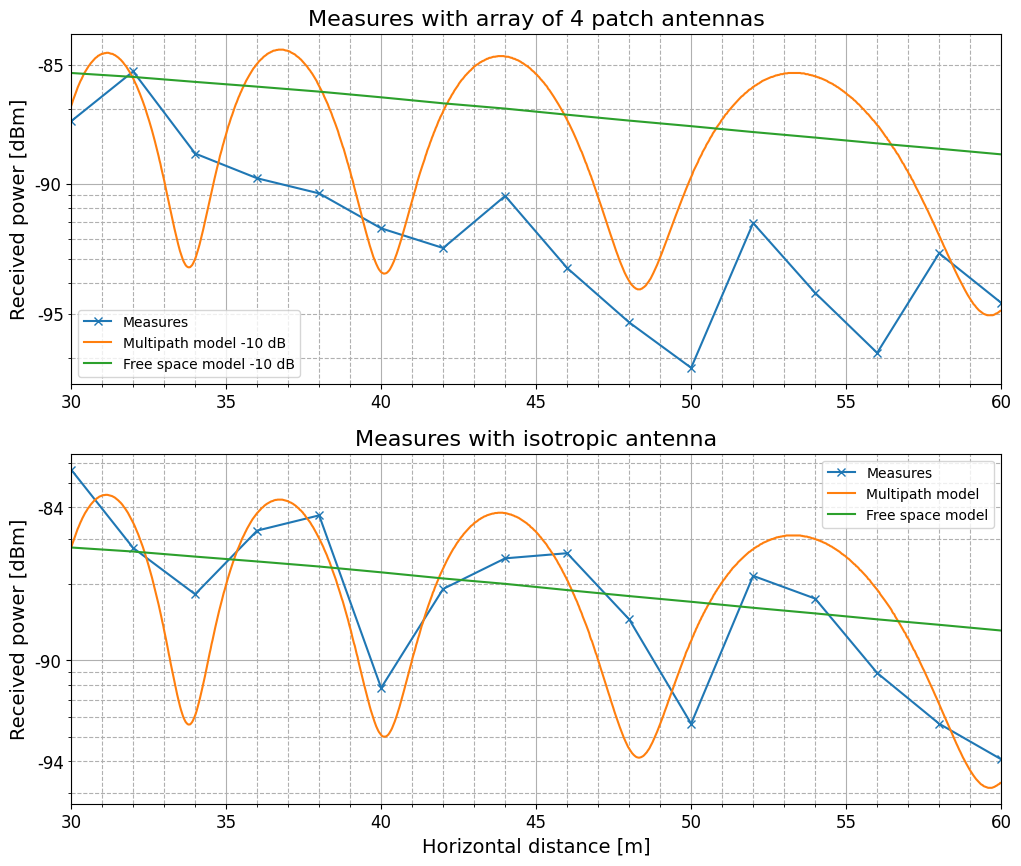

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

def decibel_fmt(x,pos=None):
    if x==0:
        return "-inf"
    else:
        return '{:.0f}'.format(10*np.log10(np.sign(x)*x))

def decibel_fmt_minor_every_5(x,pos=None):
    if x==0:
        return "-inf"
        
    db_int = round(10*np.log10(np.sign(x)*x))
    if db_int % 5 != 0 or db_int % 10 == 0:
        return ''
    else:
        return '{:.0f}'.format(10*np.log10(np.sign(x)*x))

def decibel_fmt_minor_end_4(x,pos=None):
    if x==0:
        return "-inf"
        
    db_int = round(10*np.log10(np.sign(x)*x))
    if (db_int != -94 and db_int != -84) or db_int % 10 == 0:
        return ''
    else:
        return '{:.0f}'.format(10*np.log10(np.sign(x)*x))


linealDir = linearize(np_to_list(pwDir))
linealIso = linearize(np_to_list(pwIso))
linealFsPatch = linearize(np_to_list(fsPatch))
linealFsIso = linearize(np_to_list(fsIso))
linealDirTeo = linearize(np_to_list(pwDirTeo))
linealIsoTeo = linearize(np_to_list(pwIsoTeo))

ax1.plot(d, linealDir, label="Measures", marker="x")
ax2.plot(d, linealIso, label="Measures", marker="x")

ax1.plot(horDTeo, linealDirTeo, label="Multipath model -10 dB")
ax2.plot(horDTeo, linealIsoTeo, label="Multipath model")

ax1.plot(d, linealFsPatch, label="Free space model -10 dB")
ax2.plot(d, linealFsIso, label="Free space model")

ax1.set_title("Measures with array of 4 patch antennas", fontsize=16)
ax2.set_title("Measures with isotropic antenna", fontsize=16)

ax2.set_xlabel("Horizontal distance [m]", fontsize=14)

for ax in (ax1, ax2):
    ax.set_ylabel("Received power [dBm]", fontsize=14)

    ax.minorticks_on()
    ax.tick_params(which='both', labelsize=12)
    ax.grid(True, which="minor", axis="y", linestyle="--")
    ax.grid(True, which="minor", axis="x", linestyle="--")
        
    ax.set_yscale("log")
    
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(decibel_fmt))
    if (ax == ax1):
        ax.yaxis.set_minor_formatter(mtick.FuncFormatter(decibel_fmt_minor_every_5))
    elif (ax == ax2):
        ax.yaxis.set_minor_formatter(mtick.FuncFormatter(decibel_fmt_minor_end_4))
    
    ax.set_xlim(30, 60)
    ax.legend()
    ax.grid()


fig.savefig("multipath_radial.png", dpi=400)
fig.savefig("multipath_radial.pdf", bbox_inches="tight")

In [40]:
def modelMultipathHeight(h: float) -> float:
    """ h: Altura [m]
        return: potencia teorica [dBm]"""
    Rx_to_Tx = 45 + (height_Tx - h)*1j
    R = np.abs(Rx_to_Tx)
    downtilt_angle_rad = np.angle(Rx_to_Tx)

    Rs = np.abs(45 + (height_Tx + h)*1j)
    ts = np.arctan((height_Tx + h)/45)

    Mp = 1 + np.sqrt((Gain_Tx(ts)*Gain_Rx(ts)) / (Gain_Tx(downtilt_angle_rad)*Gain_Rx(downtilt_angle_rad)))* -(0.5) * np.exp(-1j*angular_wavenumber*(Rs-R))
    return Wdisp + to_dBV(wavelength/(4*np.pi*R)) + to_dB(Gain_Tx(downtilt_angle_rad)) + to_dB(Gain_Rx(downtilt_angle_rad)) + to_dBV(Mp) + to_dB(Gain_Rx(math.pi/2-downtilt_angle_rad))- Rx_losses_dB - Tx_losses_dB

def modelFreeSpaceHeight(h: float) -> float:
    """ h: Altura [m]
        return: potencia teorica [dBm]"""
    Rx_to_Tx = 45 + (height_Tx - h)*1j
    R = np.abs(Rx_to_Tx)
    downtilt_angle_rad = np.angle(Rx_to_Tx)

    Rs = np.abs(45 + (height_Tx + h)*1j)
    ts = np.arctan((height_Tx + h)/45)

    return Wdisp + to_dBV(wavelength/(4*np.pi*R)) + to_dB(Gain_Tx(downtilt_angle_rad)) + to_dB(Gain_Rx(downtilt_angle_rad)) - Rx_losses_dB - Tx_losses_dB

In [21]:
alturaTeo = np.arange(h[0]/100, h[-1]/100, (h[-1]/100 - h[0]/100)/2000)
pwAlturaTeo = (np.vectorize(lambda x: modelMultipathHeight(x)))(alturaTeo)
pwAlturaFs = (np.vectorize(lambda x: modelFreeSpaceHeight(x)))(alturaTeo)

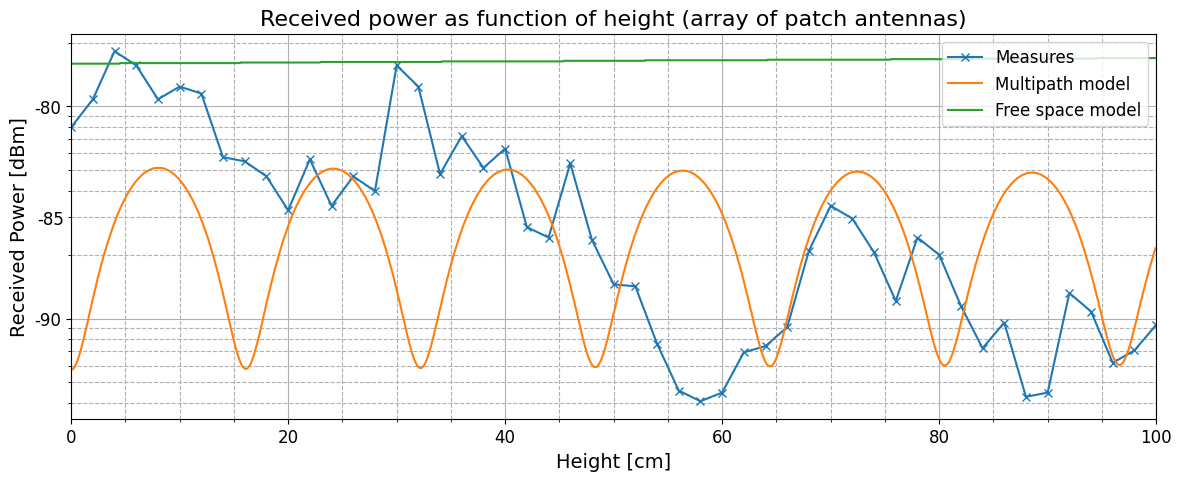

In [42]:
fig, ax = plt.subplots(figsize=(14, 5))

def decibel_fmt(x,pos=None):
    if x==0:
        return "-inf"
    else:
        return '{:.0f}'.format(10*np.log10(np.sign(x)*x))

def decibel_fmt_minor_every_5(x,pos=None):
    if x==0:
        return "-inf"
        
    db_int = round(10*np.log10(np.sign(x)*x))
    if db_int % 5 != 0 or db_int % 10 == 0:
        return ''
    else:
        #return '{:.0f}'.format(10*np.log10(np.sign(x)*x))
        return '-85'
linealH = linearize(np_to_list(pwAltura))
linealHTeo = linearize(np_to_list(pwAlturaTeo))
linealHFs = linearize(np_to_list(pwAlturaFs))
"""
for j in range(linealH.size):
    context = Context(prec=3, rounding=ROUND_UP)
    decimal_part = context.create_decimal_from_float(float(linealH[j]/10-math.floor(linealH[j]/10)))
    missing_exp = context.create_decimal_from_float(float(Decimal("10")**decimal_part))
    linealH[j] = float(Decimal("1e" + str(math.floor(linealH[j]/10)))*missing_exp)
    print(linealH[j], h[j], decimal_part, context.create_decimal_from_float(float(Decimal("10")**decimal_part)))

for j in range(linealHTeo.size):
    context = Context(prec=3, rounding=ROUND_UP)
    decimal_part = context.create_decimal_from_float(float(linealHTeo[j]/10-math.floor(linealHTeo[j]/10)))
    missing_exp = context.create_decimal_from_float(float(Decimal("10")**decimal_part))
    linealHTeo[j] = float(Decimal("1e" + str(math.floor(linealHTeo[j]/10)))*missing_exp)
    #print(linealHTeo[j], alturaTeo[j], decimal_part, context.create_decimal_from_float(float(Decimal("10")**decimal_part)))

for j in range(linealHFs.size):
    context = Context(prec=3, rounding=ROUND_UP)
    decimal_part = context.create_decimal_from_float(float(linealHFs[j]/10-math.floor(linealHFs[j]/10)))
    missing_exp = context.create_decimal_from_float(float(Decimal("10")**decimal_part))
    linealHFs[j] = float(Decimal("1e" + str(math.floor(linealHFs[j]/10)))*missing_exp)
"""

ax.set_title("Received power as function of height (array of patch antennas)", fontsize=16)

ax.plot(h, linealH, label="Measures", marker="x")
ax.plot(alturaTeo*100, linealHTeo, label="Multipath model")

ax.plot(alturaTeo*100, linealHFs, label="Free space model")

ax.set_xlabel("Height [cm]", fontsize=14)
ax.set_ylabel("Received Power [dBm]", fontsize=14)
ax.set_xlim(0, 100)

ax.set_yscale("log")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(decibel_fmt))
ax.yaxis.set_minor_formatter(mtick.FuncFormatter(decibel_fmt_minor_every_5))

plt.tick_params(which='both', labelsize=12)
ax.minorticks_on()
ax.grid(True, which="minor", axis="y", linestyle="--")
ax.grid(True, which="minor", axis="x", linestyle="--")

ax.grid()
ax.legend(loc="upper right", prop={"size": 12})

fig.savefig("multipath_height.png", dpi=400)
fig.savefig("multipath_height.pdf", bbox_inches="tight")